# Evaluation of CyteType

CyteType is a tool for automatic curation of cell types in single cell, using an LLM Annotator Agent.

In this notebook, I try the tool on a few datasets and compare it with other annotation tools.

### Install Libraries

In [27]:
!python -m pip install -q cytetype scanpy igraph leidenalg

In [28]:
import anndata
import scanpy as sc
import cytetype
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Initialize Paul15 dataset

The Paul et al 2015 dataset is a small single-cell dataset of myeloid cells, available from scanpy. The Cell types have been manually annotated, meaning we can compare cytetype's predictions against the true values.

In [29]:
#adata = sc.datasets.paul15()


In [30]:
import os
import scanpy as sc

if not os.path.exists("paul15_small.h5ad"):
    adata = sc.datasets.paul15()
    adata.write("paul15_small.h5ad")
else:
    adata = sc.read("paul15_small.h5ad")


### Process the data - compute clusters, etc

In [31]:
adata.obs["paul15_clusters"]

,paul15_clusters
W31105,7MEP
W31106,15Mo
W31107,3Ery
W31108,15Mo
W31109,3Ery
...,...
W39164,2Ery
W39165,13Baso
W39166,7MEP
W39167,15Mo


In [32]:

# Load and preprocess your data
adata.var["gene_symbols"] = adata.var_names

# We compute the clusters as suggested by the tutorial
# However, this produces 10 clusters. We are going to use the 19
# clusters from the original paper, which are stored in the `paul15_clusters` column.
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.rank_genes_groups(adata, groupby='paul15_clusters', method='t-test')

# Initialize CyteType (performs data preparation)
annotator = cytetype.CyteType(
    adata,
    group_key='paul15_clusters',           # Required: cluster column name
    rank_key='rank_genes_groups',          # DE results key (default)
    gene_symbols_column='gene_symbols',    # Gene symbols column (default)
    n_top_genes=50,                        # Top marker genes per cluster
    #results_prefix='cytetype'              # Prefix for result columns
)

Using coordinates from 'X_pca' for visualization.
Calculating expression percentages.
Extracting marker genes.
Preparing visualization data with sampling.
Using first 2 dimensions of 'X_pca' for visualization.
Extracted 2730 coordinate points (sampled from 2730 total cells)
Data preparation completed. Ready for submitting jobs.


In [33]:
adata.obs

,paul15_clusters,leiden
W31105,7MEP,5
W31106,15Mo,6
W31107,3Ery,0
W31108,15Mo,4
W31109,3Ery,0
...,...,...
W39164,2Ery,1
W39165,13Baso,3
W39166,7MEP,5
W39167,15Mo,4


In [34]:
# How many clusters are there?
print(f"Number of clusters: {len(adata.obs['paul15_clusters'].unique())}")
adata.obs['paul15_clusters'].value_counts().sort_index()


Number of clusters: 19


,count
paul15_clusters,
1Ery,43
2Ery,329
3Ery,246
4Ery,124
5Ery,180
6Ery,173
7MEP,167
8Mk,68
9GMP,63


In [35]:
# Cluster annotation from original paper
adata.obs


,paul15_clusters,leiden
W31105,7MEP,5
W31106,15Mo,6
W31107,3Ery,0
W31108,15Mo,4
W31109,3Ery,0
...,...,...
W39164,2Ery,1
W39165,13Baso,3
W39166,7MEP,5
W39167,15Mo,4


### Call the Agent! Run the annotation

In [38]:
# Run annotation
adata = annotator.run(
    study_context="Mouse bone marrow cells undergoing myeloid differentiation"
)

# View results
#print(adata.obs.cytetype_leiden)

Waiting for results for job ID: 1935a044-2439-4183-98c7-530647404250
View the automatically updating visualization report at: https://nygen-labs-prod--cytetype-api.modal.run/report/1935a044-2439-4183-98c7-530647404250
250702:1518:58 |INFO| [STARTING WORKFLOWS]: Job ID: 1935a044-2439-4183-98c7-530647404250
250702:1518:58 |INFO| [WORKFLOW STEP 1/3]: Generating context summary
250702:1519:16 |INFO| [WORKFLOW STEP 2/4]: Running complete annotation pipeline for each cluster
250702:1519:33 |INFO| [Cluster: 5] Attempt 1: Running annotation pipeline...
250702:1519:39 |INFO| [Cluster: 1] Attempt 1: Running annotation pipeline...
250702:1519:41 |INFO| [Cluster: 4] Attempt 1: Running annotation pipeline...
250702:1519:44 |INFO| [Cluster: 3] Attempt 1: Running annotation pipeline...
250702:1521:48 |INFO| [Cluster: 2] Attempt 1: Running annotation pipeline...
250702:1523:49 |SUCCESS| [Cluster: 5] Annotation pipeline completed in 263.45s after 1 attempt(s)
250702:1524:14 |INFO| [Cluster: 6] Attempt 

### Compare annotation with existing one

The original annotation are more granular than the ones from Cytetype, so we manually create a dictionary to make a comparison.

In [39]:
print(adata.obs)

       paul15_clusters leiden cytetype_annotation_paul15_clusters  \
W31105            7MEP      5            Megakaryocyte progenitor   
W31106            15Mo      6                          Neutrophil   
W31107            3Ery      0                      Erythroid cell   
W31108            15Mo      4                          Neutrophil   
W31109            3Ery      0                      Erythroid cell   
...                ...    ...                                 ...   
W39164            2Ery      1                        Erythroblast   
W39165          13Baso      3               Neutrophil progenitor   
W39166            7MEP      5            Megakaryocyte progenitor   
W39167            15Mo      4                          Neutrophil   
W39168            3Ery      0                      Erythroid cell   

       cytetype_cellOntologyTerm_paul15_clusters  
W31105                                CL_0000553  
W31106                                CL_0000775  
W31107            

In [41]:
print(adata.obs.cytetype_annotation_paul15_clusters.unique().to_list())

['Megakaryocyte progenitor', 'Neutrophil', 'Erythroid cell', 'Erythroid cells', 'Erythroblast', 'Neutrophil-myeloid progenitor', 'Neutrophil progenitor', 'Megakaryocyte', 'Dendritic cell progenitor', 'Myeloid Progenitor', 'Erythrocyte', 'Early erythroid progenitor', 'Natural killer cell', 'Basophil', 'Basophil/Eosinophil Progenitor', 'Dendritic cell']


/tmp/ipython-input-41-2255399537.py:1: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  print(adata.obs.cytetype_annotation_paul15_clusters.unique().to_list())


In [40]:
label_map = {
    '1Ery': 'Erythroblast',
    '2Ery': 'Erythroid precursor',
    '3Ery': 'Erythroblast',
    '4Ery': 'Erythroid precursor',
    '5Ery': 'Erythroid cell',
    '6Ery': 'Erythroid progenitor',

    '7MEP': 'Myeloid progenitor cell',
    '8Mk': 'Megakaryocyte',
    '9GMP': 'Hematopoietic progenitor cell',
    '10GMP': 'Hematopoietic progenitor cell',

    '11DC': 'Antigen-presenting myeloid cell',
    '12Baso': 'Mast cell',
    '13Baso': 'Mast cell',

    '14Mo': 'Neutrophil promyelocyte',
    '15Mo': 'Neutrophil promyelocyte',

    '16Neu': 'Neutrophil',
    '17Neu': 'Neutrophil',

    '18Eos': 'Eosinophil',
    '19Lymph': 'Natural Killer (NK) cell'
}


In [42]:
adata.obs["true_broad"] = adata.obs["cytetype_annotation_paul15_clusters"].map(label_map)

conf_mat = pd.crosstab(adata.obs["true_broad"], adata.obs["cytetype_annotation_paul15_clusters"], normalize='index')
conf_mat

cytetype_annotation_paul15_clusters
true_broad


In [43]:
conf_mat

cytetype_annotation_paul15_clusters
true_broad


In [44]:
# Plot Confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt=".2f", cbar=True)
plt.title("CyteType vs Paul15 Broad Cell Type Mapping")
plt.ylabel("True Label (Paul15 Broad)")
plt.xlabel("Predicted Label (CyteType)")
plt.tight_layout()
plt.show()

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1000x600 with 0 Axes>

## Repeating the confusion matrix, using the original labels


In the code above we had to manually match the Paul 15 labels with the ones generated by cytetype. Here we use the original lables, although we expand them to make it more readable, and we keep the original values.


In [45]:
import pandas as pd

# Step 1: Mapping from cluster ID to full name
paul15_label_fullname = {
    '1Ery': '1Ery - Early erythroid progenitors',
    '2Ery': '2Ery - Intermediate erythroid stage',
    '3Ery': '3Ery - Late erythroid / erythroblast',
    '4Ery': '4Ery - Terminally differentiating erythrocytes',
    '5MEP': '5MEP - Megakaryocyte-Erythroid Progenitor',
    '6MEP': '6MEP - Megakaryocyte-Erythroid Progenitor (more mature)',
    '7MEP': '7MEP - Megakaryocyte-Erythroid Progenitor (late stage)',
    '8GMP': '8GMP Granulocyte–monocyte progenitor',
    '9DC':  '9DC - Dendritic cell progenitors',
    '10Baso': '10Baso - Basophil progenitors',
    '11Mo': '11Mo - Monocyte progenitors',
    '12Mo': '12Mo - Differentiated monocyte progenitors',
    '13Baso': '13Baso - Mature basophil progenitors',
    '14Mo': '14Mo - Late-stage monocytes',
    '15Mo': '15Mo - Mature monocytes',
    '16Neu': '16Neu - Neutrophil progenitors',
    '17Neu': '17Neu - Late-stage neutrophils',
    '18Eos': '18Eos - Eosinophil progenitors',
    '19Lymph': '19Lymph - Lymphoid-like cells (NK/T precursors or contaminants)',
}

# Step 2: Map full names into obs
adata.obs["paul15_fullname"] = adata.obs["paul15_clusters"].map(paul15_label_fullname)
adata.obs.head()


,paul15_clusters,leiden,cytetype_annotation_paul15_clusters,cytetype_cellOntologyTerm_paul15_clusters,true_broad,paul15_fullname
W31105,7MEP,5,Megakaryocyte progenitor,CL_0000553,NaN,7MEP - Megakaryocyte-Erythroid Progenitor (lat...
W31106,15Mo,6,Neutrophil,CL_0000775,NaN,15Mo - Mature monocytes
W31107,3Ery,0,Erythroid cell,CL_0000764,NaN,3Ery - Late erythroid / erythroblast
W31108,15Mo,4,Neutrophil,CL_0000775,NaN,15Mo - Mature monocytes
W31109,3Ery,0,Erythroid cell,CL_0000764,NaN,3Ery - Late erythroid / erythroblast


In [ ]:
adata.obs.cytetype_paul15_clusters.value_counts()

In [47]:

# Step 3: Define full-name order
manual_order_full = list(paul15_label_fullname.values())


# Step 4: Create and reorder confusion matrix
conf_mat_full = pd.crosstab(
    adata.obs["paul15_fullname"],
    adata.obs["cytetype_annotation_paul15_clusters"],
    normalize='index'
)
# Only keep labels that exist in the confusion matrix
existing_labels = [label for label in manual_order_full if label in conf_mat_full.index]

# Reorder based on existing labels only
conf_mat_ordered = conf_mat_full.loc[existing_labels]

# Optional: reorder columns if matching set
if all(label in conf_mat_ordered.columns for label in manual_order_full):
    conf_mat_ordered = conf_mat_ordered[manual_order_full]

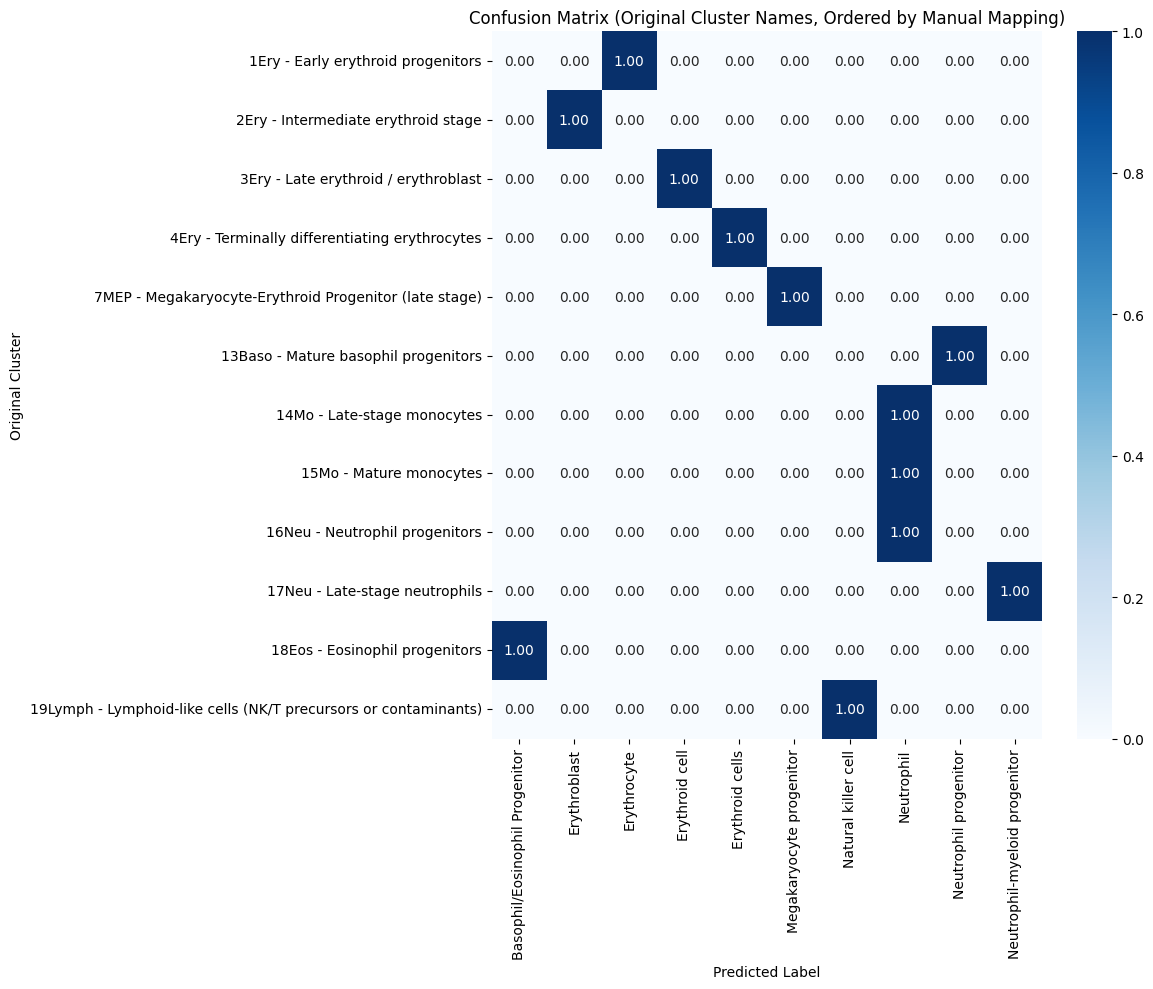

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(conf_mat_ordered, annot=True, fmt=".2f", cmap="Blues", cbar=True)

plt.title("Confusion Matrix (Original Cluster Names, Ordered by Manual Mapping)")
plt.xlabel("Predicted Label")
plt.ylabel("Original Cluster")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [55]:
adata.obs

,paul15_clusters,leiden,cytetype_annotation_paul15_clusters,cytetype_cellOntologyTerm_paul15_clusters,true_broad,paul15_fullname
W31105,7MEP,5,Megakaryocyte progenitor,CL_0000553,NaN,7MEP - Megakaryocyte-Erythroid Progenitor (lat...
W31106,15Mo,6,Neutrophil,CL_0000775,NaN,15Mo - Mature monocytes
W31107,3Ery,0,Erythroid cell,CL_0000764,NaN,3Ery - Late erythroid / erythroblast
W31108,15Mo,4,Neutrophil,CL_0000775,NaN,15Mo - Mature monocytes
W31109,3Ery,0,Erythroid cell,CL_0000764,NaN,3Ery - Late erythroid / erythroblast
...,...,...,...,...,...,...
W39164,2Ery,1,Erythroblast,CL_0000765,NaN,2Ery - Intermediate erythroid stage
W39165,13Baso,3,Neutrophil progenitor,CL_0000836,NaN,13Baso - Mature basophil progenitors
W39166,7MEP,5,Megakaryocyte progenitor,CL_0000553,NaN,7MEP - Megakaryocyte-Erythroid Progenitor (lat...
W39167,15Mo,4,Neutrophil,CL_0000775,NaN,15Mo - Mature monocytes


In [54]:
sc.pl.embedding(adata, basis='umap', color='cytetype_annotation_cell_type')

KeyError: "Could not find 'umap' or 'X_umap' in .obsm"

In [ ]:
adata.obs.cytetype_paul15_clusters.value_counts()

## What if we give the wrong description?

Let's give a wrong instruction to CyteType, for example by saying that this is a retina dataset in Zebrafish, to see if it still returns good results

In [50]:
adata2 = adata.copy()
# Initialize CyteType (performs data preparation)
annotator = cytetype.CyteType(
    adata2,
    group_key='paul15_clusters',
    rank_key='rank_genes_groups',
    gene_symbols_column='gene_symbols',
    n_top_genes=50,
)

Using coordinates from 'X_pca' for visualization.
Calculating expression percentages.
Extracting marker genes.
Preparing visualization data with sampling.
Using first 2 dimensions of 'X_pca' for visualization.
Extracted 2730 coordinate points (sampled from 2730 total cells)
Data preparation completed. Ready for submitting jobs.


In [51]:
adata2 = annotator.run(
    study_context="Zebrafish retina development during embryogenesis"
)


Waiting for results for job ID: 80c70634-db7e-4369-92f6-b22d395a5ea9
View the automatically updating visualization report at: https://nygen-labs-prod--cytetype-api.modal.run/report/80c70634-db7e-4369-92f6-b22d395a5ea9
250702:1612:02 |INFO| [STARTING WORKFLOWS]: Job ID: 80c70634-db7e-4369-92f6-b22d395a5ea9
250702:1612:02 |INFO| [WORKFLOW STEP 1/3]: Generating context summary
250702:1612:21 |INFO| [WORKFLOW STEP 2/4]: Running complete annotation pipeline for each cluster
250702:1612:39 |INFO| [Cluster: 5] Attempt 1: Running annotation pipeline...
250702:1612:42 |INFO| [Cluster: 4] Attempt 1: Running annotation pipeline...
250702:1612:44 |INFO| [Cluster: 1] Attempt 1: Running annotation pipeline...
250702:1613:09 |INFO| [Cluster: 3] Attempt 1: Running annotation pipeline...
250702:1613:58 |INFO| [Cluster: 2] Attempt 1: Running annotation pipeline...
250702:1614:01 |INFO| [Cluster: 3] No CellGuide computational markers found for CL_0000835.
250702:1614:17 |SUCCESS| [Cluster: 3] Annotation 

CyteTypeTimeoutError: Timeout while fetching results

In [ ]:
adata2.obs["true_broad"] = adata2.obs["paul15_clusters"].map(label_map)

pd.crosstab(adata2.obs["true_broad"], adata2.obs["cytetype_paul15_clusters"], normalize='index')


In [ ]:
adata2.obs["paul15_fullname"] = adata2.obs["paul15_clusters"].map(paul15_label_fullname)


In [52]:
# Create normalized confusion matrix
conf_mat = pd.crosstab(
    adata2.obs["true_broad"],
    adata2.obs["cytetype_paul15_clusters"],
    normalize='index'
)

# Plot with seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt=".2f", cbar=True)
plt.title("CyteType vs Paul15 Broad Cell Type Mapping")
plt.ylabel("True Label (Paul15 Broad)")
plt.xlabel("Predicted Label (CyteType)")
plt.tight_layout()
plt.show()

KeyError: 'cytetype_paul15_clusters'

In [ ]:
# Let's also look at the Confusion matrix with the original cluster names
conf_mat_original = pd.crosstab(adata2.obs["paul15_clusters"], adata2.obs["cytetype_paul15_clusters"], normalize='index')
conf_mat_original



# Step 3: Define full-name order
manual_order_full = list(paul15_label_fullname.values())


# Step 4: Create and reorder confusion matrix
conf_mat_full = pd.crosstab(
    adata2.obs["paul15_fullname"],
    adata2.obs["cytetype_paul15_clusters"],
    normalize='index'
)
# Only keep labels that exist in the confusion matrix
existing_labels = [label for label in manual_order_full if label in conf_mat_full.index]

# Reorder based on existing labels only
conf_mat_ordered = conf_mat_full.loc[existing_labels]

# Optional: reorder columns if matching set
if all(label in conf_mat_ordered.columns for label in manual_order_full):
    conf_mat_ordered = conf_mat_ordered[manual_order_full]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(conf_mat_ordered, annot=True, fmt=".2f", cmap="Blues", cbar=True)

plt.title("Confusion Matrix (Original Cluster Names, Ordered by Manual Mapping) - using a wrong study context")
plt.xlabel("Predicted Label")
plt.ylabel("Original Cluster")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
